# Prueba de Red Neuronal Artificial con Back Propagation

Para esta prueba utilizo un dataset generado por un script (generar-dataset.sh), en el que se simula a un usuario en un monoambiente, con hábitos muy marcados: De 23hs a 7:00hs duerme. De 7:00 a 7:30 se prepara para salir. De 7:30 a 18:30hs, los días de la semana está fuera del ambiente. Durante el fin de semana está presente. De 18:30hs a 19:30hs hay actividad variada (puede haber distintos niveles de sonido, puede o no estár prendida la luz, etc.). De 19:30 a 23hs hay actividad y la luz está prendida.

La idea es crear una red neuronal artifial que de como resultado el estado esperado del dispositivo de luz: Prendido/Apagado. Esta RNA debería además corregir los pesos de las funciones a medida que se entrena.


**IMPORTANTE:** Quiza el sensor de luminosidad debería tener el valor opuesto, ya que uno espera que la luz se prenda cuando HAY actividad y hay un nivel de luz muy bajo. Al mismo tiempo, si hay un nivel de luminosidad ALTO, el sistema no puede sacar como conclusión que hay que apagar la luz, porque entraríamos en un loop.


### Formato de los datos
Los datos creados por el script generar-dataset.sh están en el siguiente formato:


| Nombre | Tipo | Descripción | Ej. Valor |
|--------|------|---------|-------------|---------|
| **mes** | tinyint | Número de mes | 1 a 12 |
| **diaSemana** | tinyint | Número de día de la semana (Lunes 1, etc.) | 1 a 7 |
| **hora** | tinyint | Hora | 0 a 23 |
| **minuto** | tinyint | Minuto | 0 a 59 |
| **idSensor** | smallint | Identificador unico del sensor | 10123 |
| **sensCorriente** | smallint | Medición de corriente del dispositivo Lux asociado en miliamperes | 230 |
| **sensLuminosidad** | smallint | Medición del sensor de luminosidad, donde 0 = oscuro, 1 = muy iluminado | 0.871 |
| **sensSonido ** | smallint | Medición del sensor de sonido, donde 0 = silencio, 1 = alto nivel de sonoridad | 0.232 |
| **sensPresencia** | smallint | Medición del sensor de presencia, donde 0 = sin movimientos, 1 = hay movimientos | 0.856 |
| **estadoLuz** | tinyint | Indicador de estado del dispositivo Lux, donde 0 = apagado y 1 = encendido | 1 |



### Cargo algunas librerías necesarias

Librerías usadas durante este ejercicio:
* Pandas: para manipulación de grandes volúmenes de datos, en este caso importando de un csv a un array
* Matplot: Para hacer gráficos en 2D
* Numpy: Para computación científica y funciones matemáticas en general.

In [30]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

Además, más abajo voy a estar usando Scikit Learn: Un módulo que provée algoritmos de evaluación, entrenamiento y machine learning en general.

Esta línea es para que los gráficos se impriman dentro de Jupyter Notebook

In [31]:
%matplotlib inline

### Dataset
Cargo el dataset (previamente creado) y examino sus propiedades

In [32]:
df = pd.read_csv("./dataset.txt")
df.shape

(129601, 10)

El dataset tiene 129601 registros de 10 campos. La cantidad de registros está dada por 1 encabezado + 1 reg/min x 60 min x 24 horas x 90 días. Las columnas son las que se definen más arriba, y están organizadas de esta forma:

In [33]:
df.head()

,mes,diaSemana,hora,minuto,idSensor,sensCorriente,sensLuminosidad,sensSonido,sensPresencia,estadoLuz
0,1,7,0,1,1020,0,0.025,0.042,0.05,0
1,1,7,0,2,1020,0,0.024,0.067,0.04,0
2,1,7,0,3,1020,0,0.024,0.059,0.01,0
3,1,7,0,4,1020,0,0.020,0.087,0.01,0
4,1,7,0,5,1020,0,0.020,0.068,0.01,0


In [34]:
df.tail()

,mes,diaSemana,hora,minuto,idSensor,sensCorriente,sensLuminosidad,sensSonido,sensPresencia,estadoLuz
129596,3,5,23,57,1020,0,0.809,0.129,0.019,0
129597,3,5,23,58,1020,0,0.809,0.143,0.016,0
129598,4,6,23,59,1020,0,0.809,0.134,0.088,0
129599,4,6,0,0,1020,0,0.024,0.044,0.080,0
129600,4,6,0,1,1020,0,0.028,0.071,0.080,0


### Chequeo de valores null, no debería haber
Dado que el dataset se creó manualmente, todos los datos fueron completados. En la práctica, algunos valores pueden faltar ya que no todos los sensores se instalan exactamente al mismo tiempo.

In [35]:
df.isnull().values.any()

False

### Función de correlación
Hace una matriz de correlación entre las variables. Cuanto más claro el color, mayor correlación entre las variables. La diagonal debería ser amarilla, y representa la correlación de una variable con sí misma.

Esta función tiene dos entradas:
1. El dataframe panda a analizar
2. El tamáño de gráfico que se quiere imprimir

In [36]:
def plot_corr(df, size=14):
    corr = df.corr()    # data frame correlation function
    fig, ax = plt.subplots(figsize=(size, size))
    ax.matshow(corr)   # color code the rectangles by correlation value
    plt.xticks(range(len(corr.columns)), corr.columns)  # draw x tick marks
    plt.yticks(range(len(corr.columns)), corr.columns)  # draw y tick marks

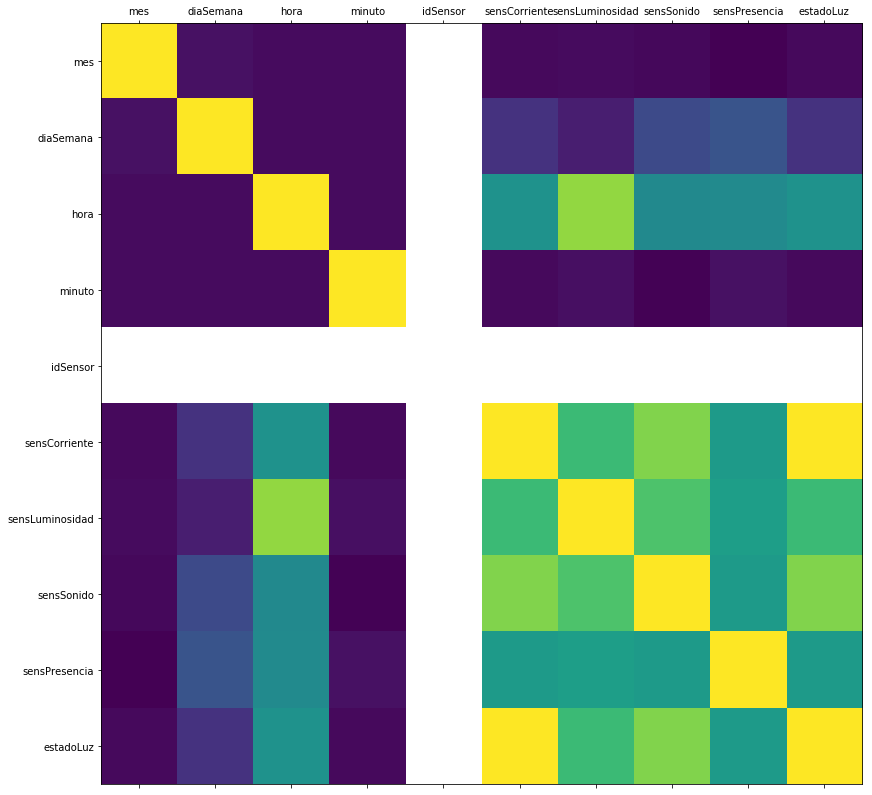

In [37]:
plot_corr(df)

In [38]:
df.corr()

,mes,diaSemana,hora,minuto,idSensor,sensCorriente,sensLuminosidad,sensSonido,sensPresencia,estadoLuz
mes,1.000000,0.013472,-0.000031,-0.000031,NaN,-0.007233,-0.002119,-0.011339,-0.032013,-0.007176
diaSemana,0.013472,1.000000,-0.000013,-0.000013,NaN,0.119509,0.055630,0.200783,0.237936,0.119782
hora,-0.000031,-0.000013,1.000000,0.000021,NaN,0.495058,0.833570,0.456487,0.460464,0.495724
minuto,-0.000031,-0.000013,0.000021,1.000000,NaN,-0.005743,0.010612,-0.025359,0.014685,-0.005761
idSensor,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
sensCorriente,-0.007233,0.119509,0.495058,-0.005743,NaN,1.000000,0.671647,0.802611,0.530242,0.998225
sensLuminosidad,-0.002119,0.055630,0.833570,0.010612,NaN,0.671647,1.000000,0.711100,0.545424,0.672811
sensSonido,-0.011339,0.200783,0.456487,-0.025359,NaN,0.802611,0.711100,1.000000,0.530075,0.804488
sensPresencia,-0.032013,0.237936,0.460464,0.014685,NaN,0.530242,0.545424,0.530075,1.000000,0.530975
estadoLuz,-0.007176,0.119782,0.495724,-0.005761,NaN,0.998225,0.672811,0.804488,0.530975,1.000000


La columna idSensor no provee información que sirva a la red neuronal, es solo un valor constante. Por otro lado, el sensor de corriente provee un valor que va a estar relacionado casi 1 a 1 con estadoLuz, ya que es lo que queremos averiguar, así que puedo eliminar ambas columnas.

In [39]:
del df['idSensor']
del df['sensCorriente']

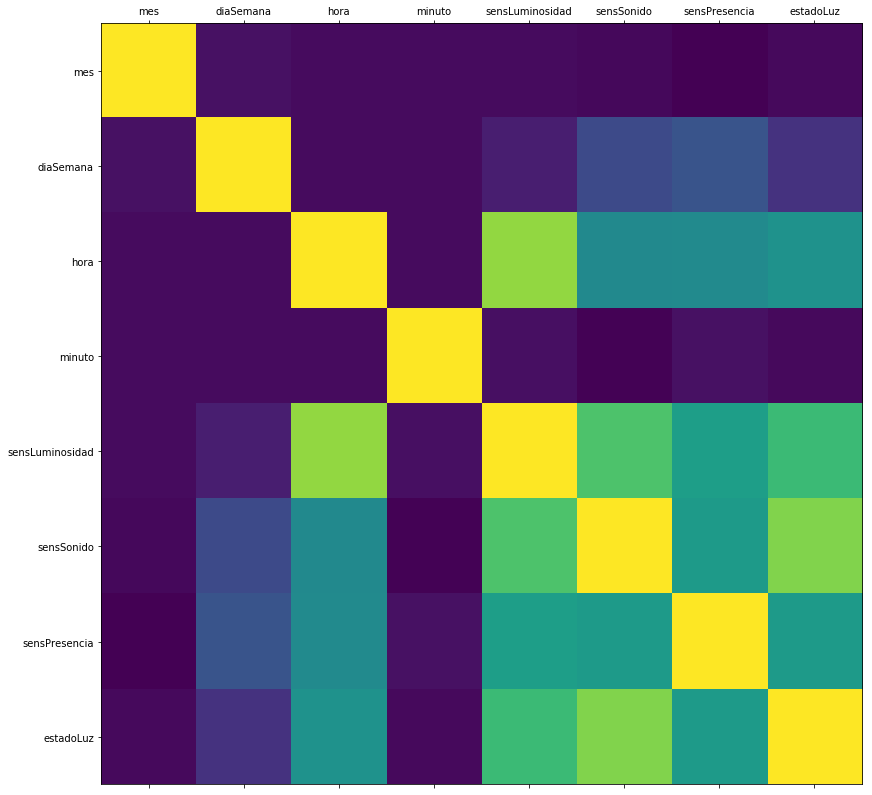

In [40]:
plot_corr(df)

De esta nueva versión del gráfico puedo sacar algunas conclusiones a simple vista:
1. No existe una correlación 1 a 1 entre ningún par de variables (lo que es bueno)
2. No exite correlación entre "mes" y "diaSemana" (lo que tiene sentido)
3. Existe cierta correlación entre los sensores con la hora o el día.
4. Existe una mayor correlación (colores más claros) entre los distintos sensores entre sí

Entonces, parece que los datos en el dataset creado a mano tienen el sentido que se le quiso dar. Lo realmente interesante va a ser obtener estos datos del mundo real y ver que relaciones surgen.



### Chequeo de distribución de clases
Debería haber dos clases, la clase en la que el dispositivo esa prendido (estadoLuz = 1) y la clase en la que está apagado.

In [41]:
num_obs = len(df)
num_true = len(df.loc[df['estadoLuz'] == 1])
num_false = len(df.loc[df['estadoLuz'] == 0])
print("Número de casos verdaderos:  {0} ({1:2.2f}%)".format(num_true, (num_true/num_obs) * 100))
print("Número de casos falsos: {0} ({1:2.2f}%)".format(num_false, (num_false/num_obs) * 100))

Número de casos verdaderos:  28506 (22.00%)
Número de casos falsos: 101095 (78.00%)


Esta distribución está un poquito desbalanceada, dado que el usuario está la mayor parte del día fuera de la oficina, y durante la noche durmiendo. Son pocas las horas de Lunes a Viernes en que está activo. Durante el fin de semana la cantidad de horas aumenta. Por ahí 60-40 hubiera estado mejor, ya que tendría más casos verdaderos para analizar. Vamos a ver como sale.

### Separando los datos para training y prueba
Para poder hacer etapas de entrenamiento y prueba, voy a separar los datos. 70% para entrenamiento, 30% para prueba. Para esto voy a usar del módulo scikit-learn la función train_test_split.

Los conjuntos de datos van a llamarse:
* X_train: Datos de entrenamiento. Las 7 columnas con los valores del mes, día, sensores, etc, compuesto por el 70% de los registros
* y_train: Resultado de entrenamiento. Columna *estadoLuz* para el 70% de los registros
* X_test: Datos para hacer la validación. Tienen el mismo formato que X_train, pero corresponden al 30% del conjunto de datos
* y_test: Resultados para validar la performance del algoritmo aplicado a X_test

O puesto de otro modo:

| Entrada (7 columnas) | Salida (1 columna)| 
|-------------|--------|
| X_train (70%) | y_train|
| X_test (30%)| y_test |

In [42]:
from sklearn.model_selection import train_test_split

feature_col_names = ['mes', 'diaSemana', 'hora', 'minuto', 'sensLuminosidad', 'sensSonido', 'sensPresencia']
predicted_class_names = ['estadoLuz']

X = df[feature_col_names].values     # Columnas del predictor (7 X m)
y = df[predicted_class_names].values # Clase predecida (1=verdadero, 0=falso) column (1 X m)
split_test_size = 0.30               # 0.30 es 30%, el tamaño para pruebas

# 42 es una respuesta común
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=split_test_size, random_state=42)

Verifico que el tamaño relativo de los sets de entrenamiento y prueba sea lo más cercano a 70-30 posible:

In [43]:
print("{0:0.2f}% en el set de entrenamiento".format((len(X_train)/len(df.index)) * 100))
print("{0:0.2f}% en el set de prueba".format((len(X_test)/len(df.index)) * 100))

70.00% en el set de entrenamiento
30.00% en el set de prueba


Verifico que la proporción de casos verdaderos y falsos se mantenga en los conjuntos de entrenamiento y test:

In [44]:
print("Verdaderos en el total     : {0} ({1:0.2f}%)".format(len(df.loc[df['estadoLuz'] == 1]), (len(df.loc[df['estadoLuz'] == 1])/len(df.index)) * 100.0))
print("Falsos en el total         : {0} ({1:0.2f}%)".format(len(df.loc[df['estadoLuz'] == 0]), (len(df.loc[df['estadoLuz'] == 0])/len(df.index)) * 100.0))
print("")
print("Verdaderos en entrenamiento: {0} ({1:0.2f}%)".format(len(y_train[y_train[:] == 1]), (len(y_train[y_train[:] == 1])/len(y_train) * 100.0)))
print("Falsos en entrenamiento    : {0} ({1:0.2f}%)".format(len(y_train[y_train[:] == 0]), (len(y_train[y_train[:] == 0])/len(y_train) * 100.0)))
print("")
print("Verdaderos en test         : {0} ({1:0.2f}%)".format(len(y_test[y_test[:] == 1]), (len(y_test[y_test[:] == 1])/len(y_test) * 100.0)))
print("Falsos en test             : {0} ({1:0.2f}%)".format(len(y_test[y_test[:] == 0]), (len(y_test[y_test[:] == 0])/len(y_test) * 100.0)))

Verdaderos en el total     : 28506 (22.00%)
Falsos en el total         : 101095 (78.00%)

Verdaderos en entrenamiento: 19880 (21.91%)
Falsos en entrenamiento    : 70840 (78.09%)

Verdaderos en test         : 8626 (22.19%)
Falsos en test             : 30255 (77.81%)


El resultado está muy bien, la proporción se mantiene lo más cerca posible.


### Entrenamiento inicial
Para este entrenamiento voy a usar otro módulo de scikit-learn: neural_network. Como lo que estamos tratando de averiguar es si la luz debe estar prendida o no, estamos hablando de un algoritmo de clasificación, y por lo tanto la función que voy a usar se llama MLPClassifier, e implementa un perceptrón multi capa (MLP) que se entrena usando backpropagation.


In [45]:
from sklearn.neural_network import MLPClassifier
clf_model = MLPClassifier(random_state=1)
clf_model.fit(X_train, y_train.ravel())

MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=1, shuffle=True,
       solver='adam', tol=0.0001, validation_fraction=0.1, verbose=False,
       warm_start=False)

### Performance usando los datos de entrenamiento
Para esto voy a importar la función metrics.

In [54]:
from sklearn import metrics

clf_predict_train = clf_model.predict(X_train)

print("Precisión en entrenamiento: {0:.4f}".format(metrics.accuracy_score(y_train, clf_predict_train)))
print()

Precisión en entrenamiento: 0.9924



### Performance usando los datos de prueba

In [53]:
clf_predict_test = clf_model.predict(X_test)

print("Precisión en test: {0:.4f}".format(metrics.accuracy_score(y_test, clf_predict_test)))
print()

Precisión en test: 0.9919



## Métricas
Los resultados de las etapas de entrenamiento y prueba son muy buenos. Demasiado buenos. Hay que analizar si no hay algún otro problema que pueda causar que cuando ponga más datos (cuando analice en tiempo real la actividad del usuario), el modelo falle miserablemente.

Para este análisis, voy a ver como se comparan los resultados, con el objetivo de entender si el modelo sirve o hay que hacer ajustes. Voy a usar dos herramientas:

### Matriz de confusión
https://es.wikipedia.org/wiki/Matriz_de_confusi%C3%B3n

Cada columna de la matriz representa el número de predicciones de cada clase, mientras que cada fila representa a las instancias en la clase real. Uno de los beneficios de las matrices de confusión es que facilitan ver si el sistema está confundiendo dos clases. 

En nuestro caso, la matriz representa lo siguiente:


| EV (Predicho Encendido y es verdad ) | EF (Predicho Encendido pero es falso) |
|------------------------------------------------|
| **AF (Predicho Apagado pero es Falso** | **AV (Predicho Apagado y es verdad)** |

Esto quiere decir que queremos los valores más altos posibles en la diagonal, y lo más cerca posible a cero en cualquier otro lado.

In [48]:
print("Matriz de confusión:")
print("{0}".format(metrics.confusion_matrix(y_test, clf_predict_test, labels=[1, 0])))

Matriz de confusión:
[[ 8477   149]
 [  165 30090]]


Estos resultados son muy buenos, el porcentaje de acertados es altísimo. El modelo es casi perfecto. Para confirmar, hay que usar la otra herramienta.


### Reporte de clasificación.
Lo primero que vamos a verificar es que tan bien se hace una predición acertada cuando se requiere que el dispositivo esté encendido. Este dato, llamado "recall" en el reporte, esta dado por:

Recall = EV / (EV + AF)

Lo segundo que queremos ver es la presición, que está dada por:

Precision = EV / (EV + EF)


In [49]:
print("Reporte de clasificación:")
print(metrics.classification_report(y_test, clf_predict_test, labels=[1,0]))

Reporte de clasificación:
             precision    recall  f1-score   support

          1       0.98      0.98      0.98      8626
          0       1.00      0.99      0.99     30255

avg / total       0.99      0.99      0.99     38881



Según este reporte, recall = 98% y precision = 98%. El modelo es muy bueno. Esto lo adjudico al hecho de que el dataset fue creado a mano, con un hábito muy marcado.

## Verificación final
¿Qué pasaría si tengo una nueva entrada en el dataset, que representa un comportamiento del usuario registrado en un momento en particular?

Por ejemplo, si digo "El Martes a las 2:16am ladro un perro mientras el usuario dormia", se podría traducir en un registro como:

| mes |	diaSemana | hora | minuto | sensLuminosidad | sensSonido | sensPresencia |
|-|
| 4 | 2 | 2 | 16 | 0.020 | 0.400 | 0.100 |

Uno esperaría que a pesar de la detección de sonido y de presencia (el usuario se mueve), la luz debería estar apagada de todos modos. Veamos que resultado muestra el modelo.

In [50]:
X_new_test = [[4, 2, 2, 16, 0.02, 0.4, 0.2]]
clf_predict_new_test = clf_model.predict(X_new_test)

print ("Resultado: ", clf_predict_new_test)

Resultado:  [0]


El resultado es el esperado. Como dije al principio, quizá el sensor de luminosidad está demasiado relacionado con el resultado, es algo para ver. De todos modos, este modelo parece algo que podemos aplicar, extendiendolo a más de un dispositivo por ambiente.

Lo otro que podemos hacer es usar la salida de esta red como entrada para una red general, que represente la casa.